# Hyperparameter tuning by grid-search

In the previous notebook, we saw that hyperparameters can affect the
statistical performance of a model. In this notebook, we will show how to
optimize hyperparameters using a grid-search approach.

## Our predictive model

Let us reload the dataset as we did previously:

In [1]:
from sklearn import set_config

set_config(display="diagram")

In [2]:
import pandas as pd

adult_census = pd.read_csv("data/adult-census.csv")

We extract the column containing the target.

In [3]:
target_name = "class"
target = adult_census[target_name]
target

0         <=50K
1         <=50K
2          >50K
3          >50K
4         <=50K
          ...  
48837     <=50K
48838      >50K
48839     <=50K
48840     <=50K
48841      >50K
Name: class, Length: 48842, dtype: object

We drop from our data the target and the `"education-num"` column which
duplicates the information from the `"education"` column.

In [4]:
data = adult_census.drop(columns=[target_name, "education-num"])
data.head()

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25,Private,226802,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,38,Private,89814,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,28,Local-gov,336951,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,44,Private,160323,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,18,?,103497,Some-college,Never-married,?,Own-child,White,Female,0,0,30,United-States


Once the dataset is loaded, we split it into a training and testing sets.

In [5]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=42)

We will define a pipeline as seen in the first module. It will handle both
numerical and categorical features.

As we will use a tree-based model as a predictor, here we apply an ordinal
encoder on the categorical features: it encodes every category with an
arbitrary integer. For simple models such as linear models, a one-hot encoder
should be preferred. But for complex models, in particular tree-based models,
the ordinal encoder is useful as it avoids having high-dimensional
representations.

First we select all the categorical columns.

In [6]:
from sklearn.compose import make_column_selector as selector

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(data)

Then we build our ordinal encoder, giving it the known categories.

In [7]:
from sklearn.preprocessing import OrdinalEncoder

categorical_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value",
                                          unknown_value=-1)

We now use a column transformer with code to select the categorical columns
and apply to them the ordinal encoder.

In [8]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('cat-preprocessor', categorical_preprocessor, categorical_columns)],
    remainder='passthrough', sparse_threshold=0)

Finally, we use a tree-based classifier (i.e. histogram gradient-boosting) to
predict whether or not a person earns more than 50 k$ a year.

In [9]:
# for the moment this line is required to import HistGradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline

model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier",
     HistGradientBoostingClassifier(random_state=42, max_leaf_nodes=4))])
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('cat-preprocessor',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier',
                 HistGradientBoostingClassifier(max_leaf_nodes=4,
                                                random_state=42))])

## Tuning using a grid-search

Instead of manually writing the two `for` loops, scikit-learn provides a
class called `GridSearchCV` which implement the exhaustive search implemented
during the exercise.

Let see how to use the `GridSearchCV` estimator for doing such search.
Since the grid-search will be costly, we will only explore the combination
learning-rate and the maximum number of nodes.

In [10]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__learning_rate': (0.05, 0.1, 0.5, 1, 5),
    'classifier__max_leaf_nodes': (3, 10, 30, 100)}
model_grid_search = GridSearchCV(model, param_grid=param_grid,
                                 n_jobs=2, cv=2)
model_grid_search.fit(data_train, target_train)

Wall time: 24.8 s


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          sparse_threshold=0,
                                                          transformers=[('cat-preprocessor',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['workclass',
                                                                          'education',
                                                                          'marital-status',
                                                                          'occupation',
                                                                          'relationship',
                                                                          'race',
                                                                          'sex',
                                                                          'native-country'])])),
                                       ('classifier',
                                        HistGradientBoostingClassifier(max_leaf_nodes=4,
                                                                       random_state=42))]),
             n_jobs=2,
             param_grid={'classifier__learning_rate': (0.05, 0.1, 0.5, 1, 5),
                         'classifier__max_leaf_nodes': (3, 10, 30, 100)})

Finally, we will check the accuracy of our model using the test set.

In [11]:
accuracy = model_grid_search.score(data_test, target_test)
print(
    f"The test accuracy score of the grid-searched pipeline is: "
    f"{accuracy:.2f}"
)

The test accuracy score of the grid-searched pipeline is: 0.88


<div class="admonition warning alert alert-danger">
<p class="first admonition-title" style="font-weight: bold;">Warning</p>
<p>Be aware that the evaluation should normally be performed in a
cross-validation framework by providing <tt class="docutils literal">model_grid_search</tt> as a model to
the <tt class="docutils literal">cross_validate</tt> function.</p>
<p class="last">Here, we are using a single train-test split to highlight the specificities
of the <tt class="docutils literal">model_grid_search</tt> instance. We will show such examples in the last
section of this notebook.</p>
</div>

The `GridSearchCV` estimator takes a `param_grid` parameter which defines
all hyperparameters and their associated values. The grid-search will be in
charge of creating all possible combinations and test them.

The number of combinations will be equal to the product of the
number of values to explore for each parameter (e.g. in our example 4 x 4
combinations). Thus, adding new parameters with their associated values to be
explored become rapidly computationally expensive.

Once the grid-search is fitted, it can be used as any other predictor by
calling `predict` and `predict_proba`. Internally, it will use the model with
the best parameters found during `fit`.

Get predictions for the 5 first samples using the estimator with the best
parameters.

In [12]:
model_grid_search.predict(data_test.iloc[0:5])

array([' <=50K', ' <=50K', ' >50K', ' <=50K', ' >50K'], dtype=object)

You can know about these parameters by looking at the `best_params_`
attribute.

In [13]:
print(f"The best set of parameters is: "
      f"{model_grid_search.best_params_}")

The best set of parameters is: {'classifier__learning_rate': 0.1, 'classifier__max_leaf_nodes': 30}


The accuracy and the best parameters of the grid-searched pipeline are
similar to the ones we found in the previous exercise, where we searched the
best parameters "by hand" through a double for loop.

In addition, we can inspect all results which are stored in the attribute
`cv_results_` of the grid-search. We will filter some specific columns
from these results.

In [14]:
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__max_leaf_nodes,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
6,1.199293,0.058343,0.235870,0.037401,0.1,30,"{'classifier__learning_rate': 0.1, 'classifier...",0.867766,0.867649,0.867708,0.000058,1
2,1.667541,0.005984,0.266288,0.004986,0.05,30,"{'classifier__learning_rate': 0.05, 'classifie...",0.867220,0.866557,0.866889,0.000331,2
5,0.706613,0.012464,0.251325,0.007975,0.1,10,"{'classifier__learning_rate': 0.1, 'classifier...",0.866729,0.866557,0.866643,0.000086,3
9,0.356547,0.046376,0.216920,0.024435,0.5,10,"{'classifier__learning_rate': 0.5, 'classifier...",0.865855,0.866121,0.865988,0.000133,4
3,4.497474,0.007479,0.252824,0.007480,0.05,100,"{'classifier__learning_rate': 0.05, 'classifie...",0.866456,0.865029,0.865742,0.000713,5


Let us focus on the most interesting columns and shorten the parameter
names to remove the `"param_classifier__"` prefix for readability:

In [15]:
# get the parameter names
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]

In [16]:
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,learning_rate,max_leaf_nodes,mean_test_score,std_test_score,rank_test_score
6,0.1,30,0.867708,0.000058,1
2,0.05,30,0.866889,0.000331,2
5,0.1,10,0.866643,0.000086,3
9,0.5,10,0.865988,0.000133,4
3,0.05,100,0.865742,0.000713,5
7,0.1,100,0.865469,0.001096,6
8,0.5,3,0.865305,0.000815,7
10,0.5,30,0.864377,0.001150,8
1,0.05,10,0.861756,0.000105,9
12,1,3,0.860910,0.000351,10


With only 2 parameters, we might want to visualize the grid-search as a
heatmap. We need to transform our `cv_results` into a dataframe where:

- the rows will correspond to the learning-rate values;
- the columns will correspond to the maximum number of leaf;
- the content of the dataframe will be the mean test scores.

In [17]:
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score", index=["learning_rate"],
    columns=["max_leaf_nodes"])

pivoted_cv_results

max_leaf_nodes,3,10,30,100
learning_rate,,,,
0.05,0.827196,0.861756,0.866889,0.865742
0.10,0.853512,0.866643,0.867708,0.865469
0.50,0.865305,0.865988,0.864377,0.854795
1.00,0.860910,0.859927,0.851547,0.831809
5.00,0.283476,0.527581,0.618380,0.544130


We can use a heatmap representation to show the above dataframe visually.

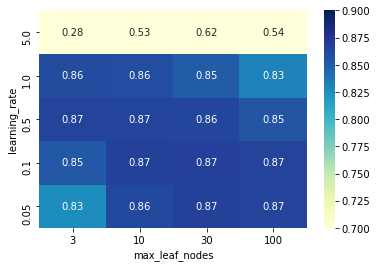

In [18]:
import seaborn as sns

ax = sns.heatmap(pivoted_cv_results, annot=True, cmap="YlGnBu", vmin=0.7,
                 vmax=0.9)
ax.invert_yaxis()

The above tables highlights the following things:

* for too high values of `learning_rate`, the statistical performance of the
  model is degraded and adjusting the value of `max_leaf_nodes` cannot fix
  that problem;
* outside of this pathological region, we observe that the optimal choice
  of `max_leaf_nodes` depends on the value of `learning_rate`;
* in particular, we observe a "diagonal" of good models with an accuracy
  close to the maximal of 0.87: when the value of `max_leaf_nodes` is
  increased, one should decrease the value of `learning_rate` accordingly
  to preserve a good accuracy.

The precise meaning of those two parameters will be explained in a latter
notebook.

For now we will note that, in general, **there is no unique optimal parameter
setting**: 6 models out of the 16 parameter configuration reach the maximal
accuracy (up to small random fluctuations caused by the sampling of the
training set).

In this notebook we have seen:

* how to optimize the hyperparameters of a predictive model via a
  grid-search;
* that searching for more than two hyperparamters is too costly;
* that a grid-search does not necessarily find an optimal solution.